# Bias Detection #

We will show the following bias measures: 

1.   Magnitude measures - mean difference
2.   Conditional measures - unexplainable mean difference

We will compare bias between detecting pedestrian at night versus detecting pedestrian at day for a given model. 
We will run the measurement on three different models, each trained on a different dataset

## Import Libraries ##

In [2]:
!wget https://s3-us-west-1.amazonaws.com/strata-bias-data2/inputdata.tar.gz
!tar -xvf inputdata.tar.gz
!mkdir outputdata

--2019-03-14 13:33:28--  https://s3-us-west-1.amazonaws.com/strata-bias-data2/inputdata.tar.gz
Resolving proxy-chain.intel.com (proxy-chain.intel.com)... 10.19.8.224
Connecting to proxy-chain.intel.com (proxy-chain.intel.com)|10.19.8.224|:912... connected.
Proxy request sent, awaiting response... 403 Forbidden
2019-03-14 13:33:29 ERROR 403: Forbidden.

inputdata/
inputdata/night_img.jpg
inputdata/day_img.jpg
inputdata/nd_frozen_inference_graph.pb
inputdata/dneq_frozen_inference_graph.pb
inputdata/dd_frozen_inference_graph.pb
inputdata/val_labels.json
inputdata/bias_utils.py
mkdir: cannot create directory ‘outputdata’: File exists


In [3]:
import tensorflow as tf
import os
import sys
import glob
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import IPython.display as dp
import cv2
import json
from functools import reduce
from inputdata import bias_utils as utils
from prettytable import PrettyTable

In [4]:
%matplotlib inline

### Display Training Data Statistics ###

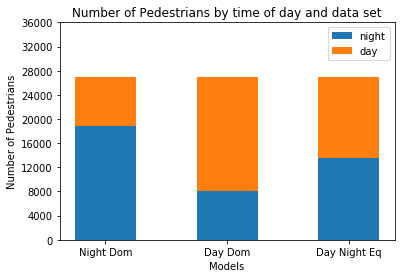

In [5]:
N = 3
night_person = (18898, 8089, 13497)
day_person = (8092, 18898, 13498)
ind = np.arange(N)

pnight = plt.bar(ind, night_person, width=0.5)
pday = plt.bar(ind, day_person , width=0.5, bottom=night_person)

plt.ylabel('Number of Pedestrians')
plt.xlabel('Models')
plt.title('Number of Pedestrians by time of day and data set')
plt.xticks(ind, ('Night Dom', 'Day Dom', 'Day Night Eq'))
plt.yticks(np.arange(0, 38000, 4000))
plt.legend((pnight[0], pday[0]), ('night', 'day'))

plt.show()

Trained three different models using three different datasets

## Define Local Variables ##

In [6]:
# contains test images
inputdir = 'inputdata'
outputdir = 'outputdata'
inputdata = glob.glob(inputdir + '/*jpg')

In [7]:
# models trained on 3 different training sets using the same type of model
NIGHT_DOM_FROZEN_GRAPH_PATH = os.path.join(inputdir, 'nd_frozen_inference_graph.pb')
DAY_DOM_FROZEN_GRAPH_PATH = os.path.join(inputdir, 'dd_frozen_inference_graph.pb')
DAYNIGHT_EQ_FROZEN_GRAPH_PATH = os.path.join(inputdir, 'dneq_frozen_inference_graph.pb')

## Process GroundTruth Labels ##

In [8]:
with open(inputdir + '/val_labels.json') as f:
    val_raw_labels = json.load(f)
    gt = utils.format_labels(val_raw_labels)
    
cat_gt = utils.group_by_key(gt, 'name')
cat_gt.keys()

dict_keys(['night_img.jpg', 'day_img.jpg'])

### Display Original Image ###

We randomly select two images, one from day, one from night to demonstrate our experiment. 
How many pedestrians can you spot in each image?

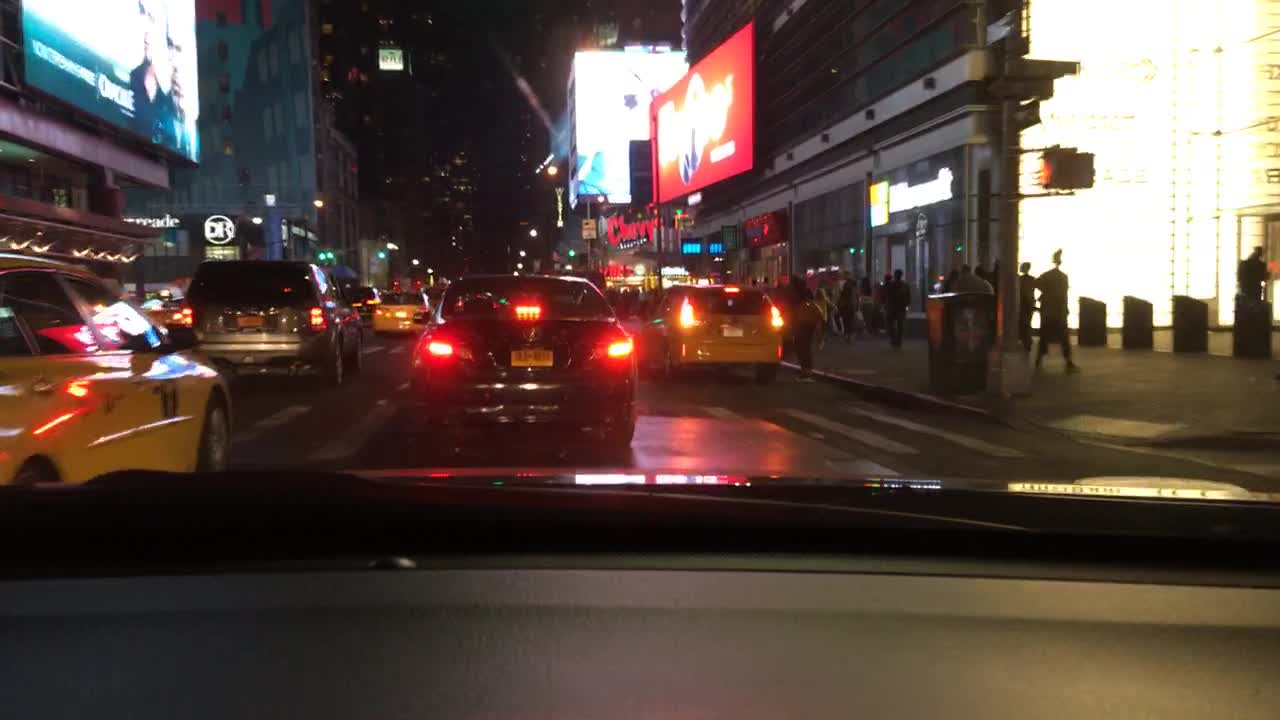

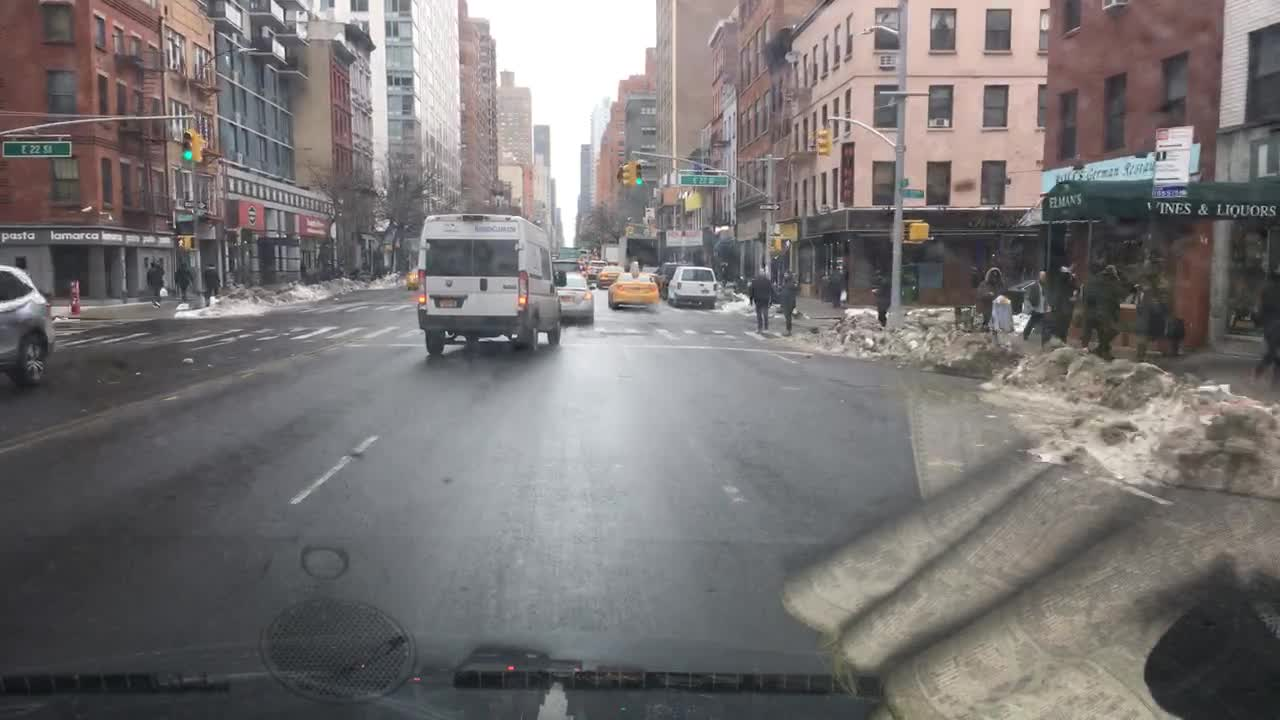

In [9]:
for img_path in inputdata:
    obj = dp.Image(filename=img_path)
    dp.display(obj)

### Ground Truth Images ###

Groundtruth image night_img.jpg has 18 Number of pedestrians
image path outputdata/gt_night_img.jpg


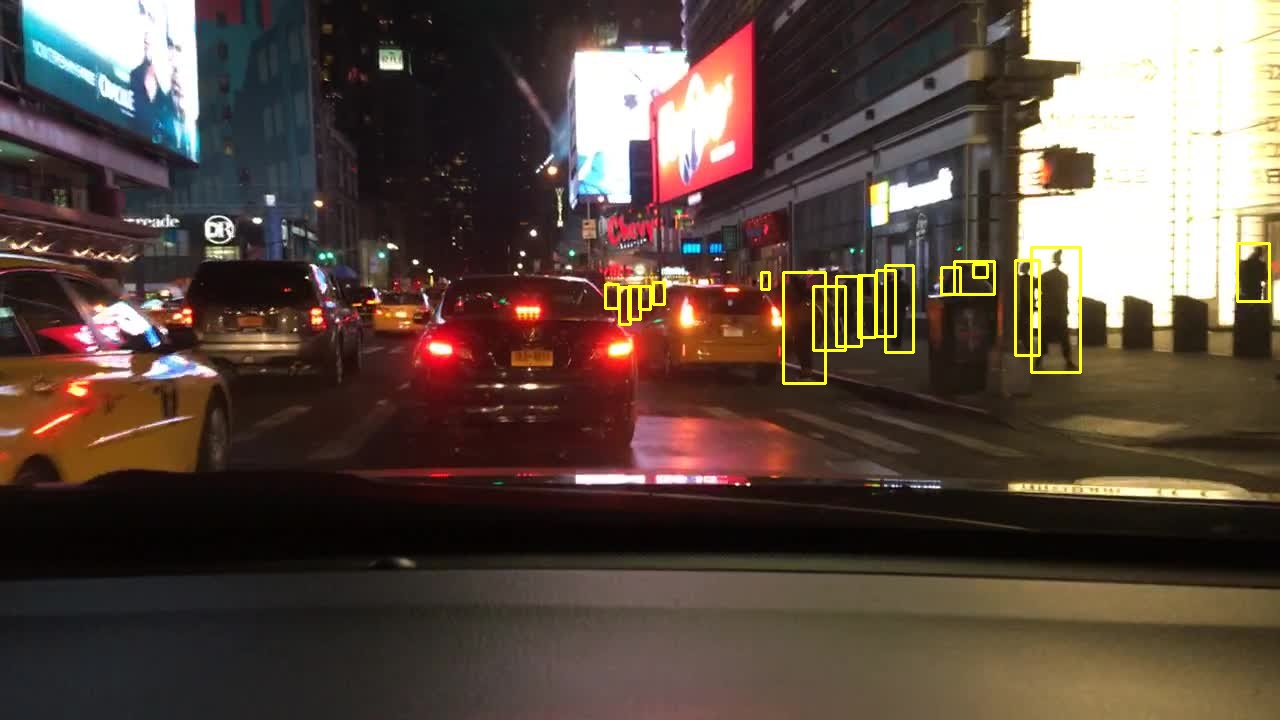

Groundtruth image day_img.jpg has 13 Number of pedestrians
image path outputdata/gt_day_img.jpg


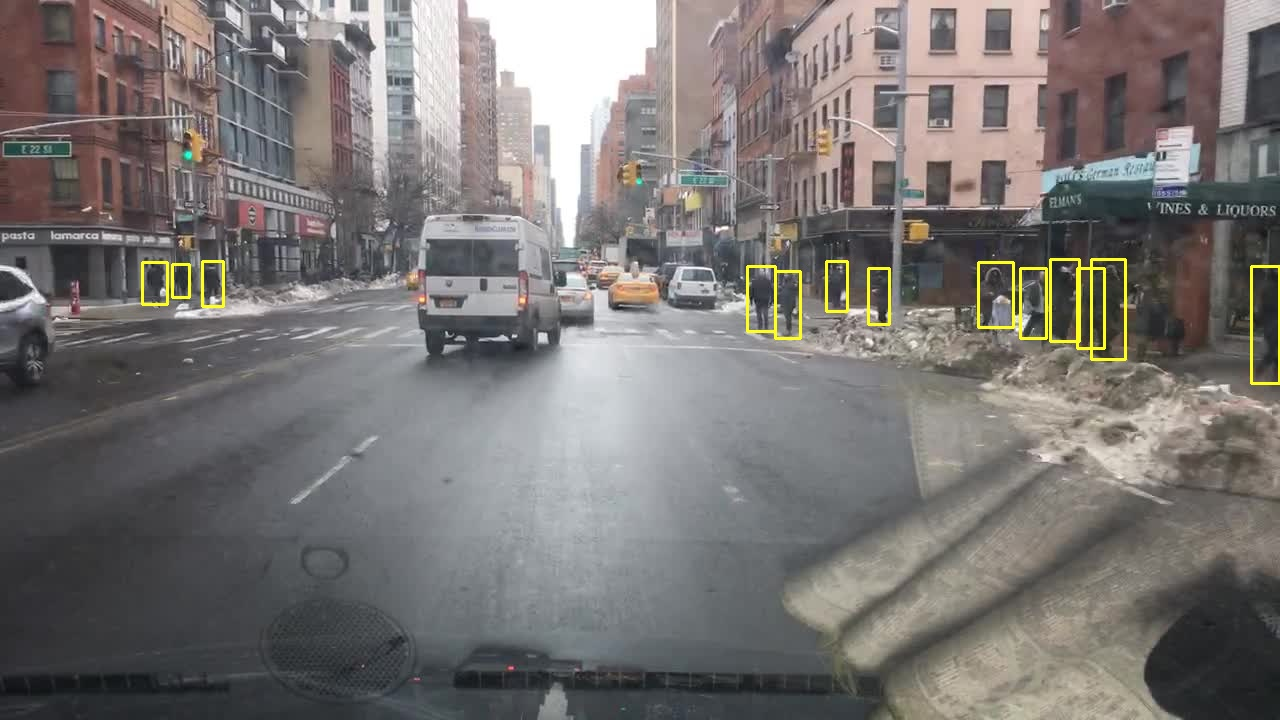

In [10]:
for name in cat_gt.keys():
    img_path = inputdir + '/' + name
    img = cv2.imread(img_path)

    # draw groundtruth rectangles on each image
    gt_img_path = outputdir + '/gt_' + name
    for i, b in enumerate(cat_gt[name]):
        bbox = [int(pos) for pos in b['bbox']]
        cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color=(30, 255, 255), thickness=2)
    cv2.imwrite(gt_img_path, img)
    print("Groundtruth image", name, "has", len(cat_gt[name]), "Number of pedestrians")
    print('image path', gt_img_path)
    dp_gt_img = dp.Image(filename=gt_img_path, format='jpg')
    dp.display(dp_gt_img)

Were you able to identify them all?

## Run Inference ##

Now let's see how well our three models perform on the test images. First we will pick the model trained on night dominated training set

### Run Inference on Night Dominated Model ###

In [11]:
night_detection_result = utils.run_inference_show_bbox(NIGHT_DOM_FROZEN_GRAPH_PATH, inputdir, outputdir, 'nightdom')

night_img.jpg Number of detected pedestrians 5
day_img.jpg Number of detected pedestrians 14


In [12]:
nd_pred = utils.format_pred(night_detection_result)

Let's visually inspect these detections

### Display Detected Images ###

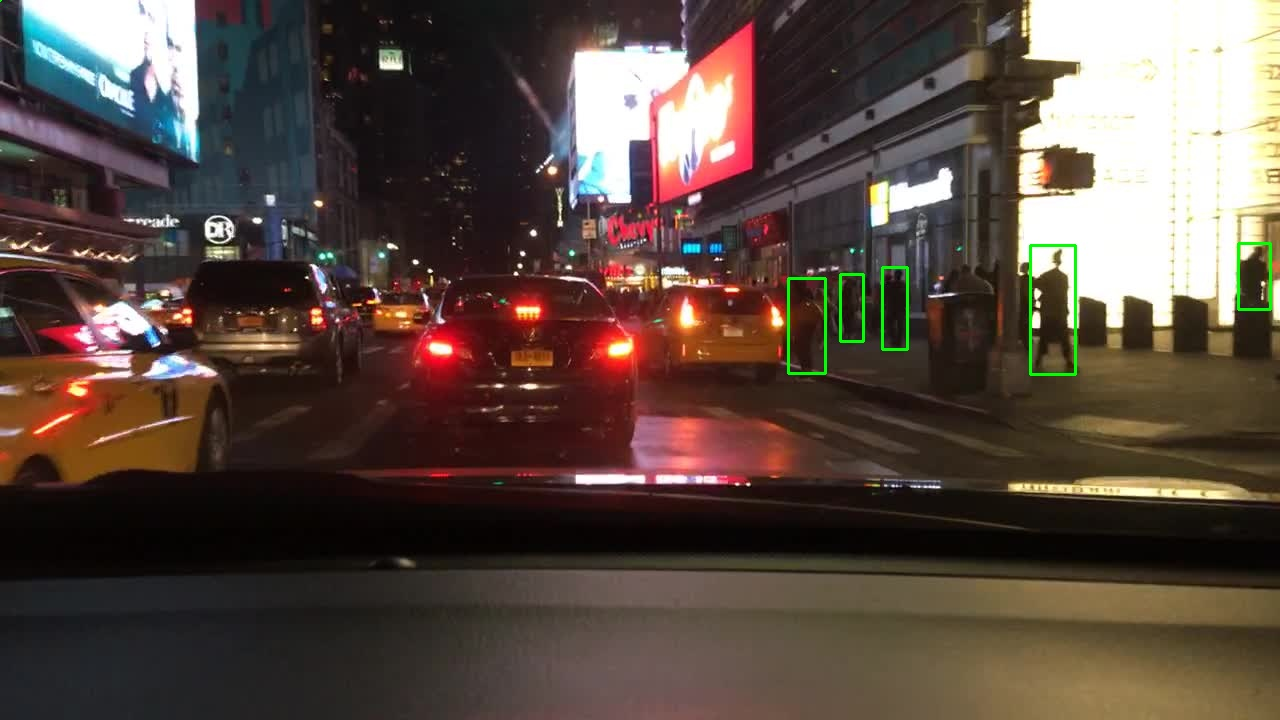

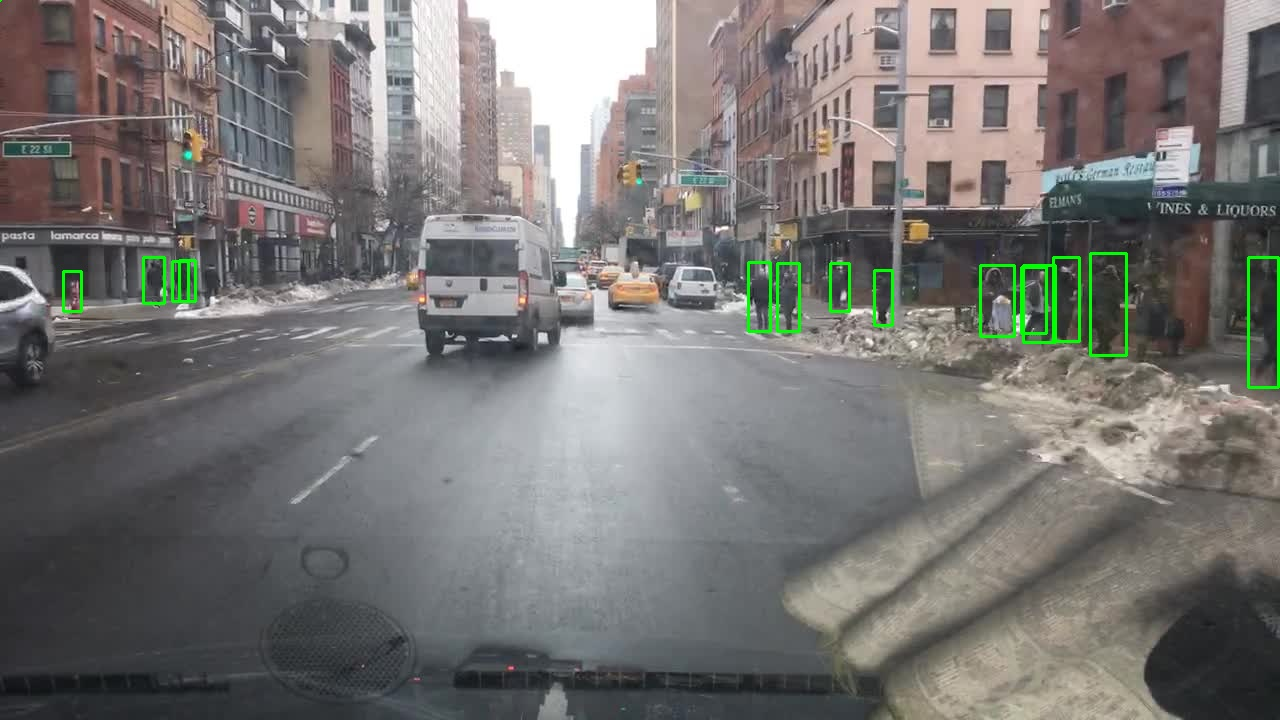

In [13]:
night_det_images = glob.glob(outputdir + '/det_nightdom*')
for img_path in night_det_images:
    dp_det_img = dp.Image(filename=img_path, format='jpg')
    dp.display(dp_det_img)

       

For night time, the night dominated model detected 5 out of 18.
For day time, the night dominated model detected 14 out of 13

Overall it did pretty well on detecting pedestrians at day, but it was having troubles with pedestrian at night for pedestrians further away and (or) pedestrians that are either truncated or occluded. 

### Run Inference for day dominated model ###

In [14]:
day_detection_result = utils.run_inference_show_bbox(DAY_DOM_FROZEN_GRAPH_PATH, inputdir, outputdir, 'daydom')
dd_pred = utils.format_pred(day_detection_result)

night_img.jpg Number of detected pedestrians 5
day_img.jpg Number of detected pedestrians 12


### Run Inference on Day Night Equal Model ###

In [15]:
daynight_detection_result = utils.run_inference_show_bbox(DAYNIGHT_EQ_FROZEN_GRAPH_PATH, inputdir, outputdir, 'daynight')
dn_pred = utils.format_pred(daynight_detection_result)

night_img.jpg Number of detected pedestrians 8
day_img.jpg Number of detected pedestrians 14


## Calculate Bias Magnitude ##

### Calculate Recall at Day vs at Night###

In [16]:
def cat_pc(gt, predictions, thresholds):
    """
    Mainly based off of https://github.com/ucbdrive/bdd-data/blob/master/bdd_data/evaluate.py
    """
    num_gts = len(gt)
    image_gts = utils.group_by_key(gt, 'name')
    image_gt_boxes = {k: np.array([[float(z) for z in b['bbox']]
                                   for b in boxes])
                      for k, boxes in image_gts.items()}
    image_gt_checked = {k: np.zeros((len(boxes), len(thresholds)))
                        for k, boxes in image_gts.items()}
    image_gt_occluded = {k: np.array([b['occluded']
                                   for b in boxes])
                      for k, boxes in image_gts.items()}
    
    num_gts_occluded = reduce(lambda x, y: int(x) + int(y), [i['occluded'] for i in gt])
    
    predictions = sorted(predictions, key=lambda x: x['score'], reverse=True)

    # go down dets and mark TPs and FPs
    nd = len(predictions)
    tp = np.zeros((nd, len(thresholds)))
    fp = np.zeros((nd, len(thresholds)))
    
    nd_occ = len(predictions)
    tp_occ = np.zeros((nd, len(thresholds)))
    fp_occ = np.zeros((nd, len(thresholds)))
    
    nd_nocc = len(predictions)
    tp_nocc = np.zeros((nd, len(thresholds)))
    fp_nocc = np.zeros((nd, len(thresholds)))
    
    for i, p in enumerate(predictions):
        box = p['bbox']
        ovmax = -np.inf
        jmax = -1
        try:
            gt_boxes = image_gt_boxes[p['name']]
            gt_checked = image_gt_checked[p['name']]
            gt_occluded = image_gt_occluded[p['name']]
        except KeyError:
            gt_boxes = []
            gt_checked = None
            gt_occluded = None
            # todo: remove later
            continue
            
        if len(gt_boxes) > 0:
            # compute overlaps
            # intersection
            ixmin = np.maximum(gt_boxes[:, 0], box[0])
            iymin = np.maximum(gt_boxes[:, 1], box[1])
            ixmax = np.minimum(gt_boxes[:, 2], box[2])
            iymax = np.minimum(gt_boxes[:, 3], box[3])
            iw = np.maximum(ixmax - ixmin + 1., 0.)
            ih = np.maximum(iymax - iymin + 1., 0.)
            inters = iw * ih

            # union
            uni = ((box[2] - box[0] + 1.) * (box[3] - box[1] + 1.) +
                   (gt_boxes[:, 2] - gt_boxes[:, 0] + 1.) *
                   (gt_boxes[:, 3] - gt_boxes[:, 1] + 1.) - inters)

            overlaps = inters / uni
            ovmax = np.max(overlaps)
            jmax = np.argmax(overlaps)
            
        for t, threshold in enumerate(thresholds):
            if ovmax > threshold:
                if gt_checked[jmax, t] == 0:
                    if gt_occluded[jmax] == True:
                        tp_occ[i, t] = 1.
                    else:
                        tp_nocc[i, t] = 1.
                    tp[i, t] = 1
                    gt_checked[jmax, t] = 1
                else:
                    if gt_occluded[jmax] == True:
                        fp_occ[i, t] = 1.
                    else:
                        fp_nocc[i, t] = 1.
                    fp[i, t] = 1.
            else:
                if gt_occluded[jmax] == True:
                    fp_occ[i, t] = 1.
                else:
                    fp_nocc[i, t] = 1.
                fp[i, t] = 1.

    # compute precision recall
    fp = np.cumsum(fp, axis=0)
    tp = np.cumsum(tp, axis=0)
    recalls = tp / float(num_gts)
    # avoid divide by zero in case the first detection matches a difficult
    # ground truth
    precisions = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)
    ap = np.zeros(len(thresholds))
    
    # occluded
    fp_occ = np.cumsum(fp_occ, axis=0)
    tp_occ = np.cumsum(tp_occ, axis=0)
    recalls_occ = tp_occ / float(num_gts_occluded) # probaly should divide by number of occluded
    precisions_occ = tp_occ / np.maximum(tp_occ + fp_occ, np.finfo(np.float64).eps)
    ap_occ = np.zeros(len(thresholds))
    
    # not occluded
    fp_nocc = np.cumsum(fp_nocc, axis=0)
    tp_nocc = np.cumsum(tp_nocc, axis=0)
    recalls_nocc = tp_nocc / float((num_gts - num_gts_occluded)) # probaly should divide by number of occluded
    precisions_nocc = tp_nocc / np.maximum(tp_nocc + fp_nocc, np.finfo(np.float64).eps)
    ap_nocc = np.zeros(len(thresholds))
    
    result = {}
    result['recall'] = np.squeeze(recalls[-1])
    result['recall_oc'] = np.squeeze(recalls_occ[-1])
    result['recall_noc'] = np.squeeze(recalls_nocc[-1])
    result['num_gts'] = num_gts
    result['num_gts_oc'] = num_gts_occluded
    
    return result

def evaluate_detection(gt, pred):
    thresholds = [0.75]
    cat_gt = utils.group_by_key(gt, 'timeofday')
    results = {}
    
    for cat in cat_gt.keys():
        results[cat] = cat_pc(cat_gt[cat], pred, thresholds)
    return results


In [17]:
dd_results = evaluate_detection(gt, dd_pred)
dn_results = evaluate_detection(gt, dn_pred)
nd_results = evaluate_detection(gt, nd_pred)

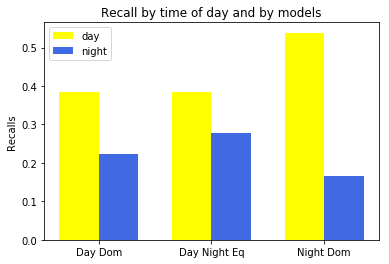

In [22]:
gridnumber = np.arange(3)
width = 0.35
fig = plt.figure()
ax = plt.subplot(111)
day_recall = ax.bar(gridnumber, 
                    [dd_results['daytime']['recall'],
                     dn_results['daytime']['recall'], 
                     nd_results['daytime']['recall']],
                     width, color='yellow')
night_recall = ax.bar(gridnumber + width, 
                    [dd_results['night']['recall'], 
                     dn_results['night']['recall'],
                     nd_results['night']['recall']], 
                     width, color='royalblue')

ax.set_xticks(gridnumber + width/2)
ax.set_xticklabels(['Day Dom', 'Day Night Eq', 'Night Dom'])   
ax.set_ylabel('Recalls')
ax.set_title('Recall by time of day and by models')
ax.legend((day_recall[0], night_recall[1]), ('day', 'night'))

We see that there is significant difference betweeen the recall of day vs night. 
However is this a fair comparison? Recall that the night image had a lot of occluded (cluttered) pedestrians. Is there a way to take this into account so our bias measurement is fair?

Before we were simply comparing recall between day vs now. Now we want to compare recalls under the same condition. 

That is:

1. compare recall at night vs recall at day when pedestrians are not occluded
2. Compare recall at night vs recall at day when pedestrians are occluded

This is call stratification

### Compare Detection Accuracy between Occluded vs Unoccluded Pedestrians ###

Let's inspect how many number of pedestrians are occluded in the day and night images

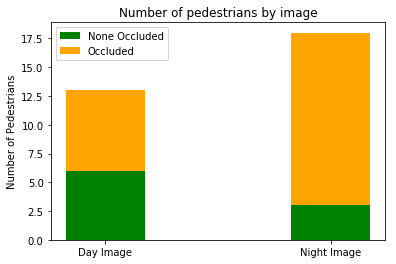

In [34]:
gridnumber = np.arange(2)
width = 0.35
fig = plt.figure()
ax = plt.subplot(111)
num_gts_oc = np.array([dd_results['daytime']['num_gts_oc'],
                     dd_results['night']['num_gts_oc']])
num_gts_noc = np.array([dd_results['daytime']['num_gts'],dd_results['night']['num_gts']] ) - num_gts_oc

bar1 = ax.bar(gridnumber, num_gts_noc,width, color='green')
bar2 = ax.bar(gridnumber, num_gts_oc, width, bottom=num_gts_noc,color='orange')


ax.set_xticks(gridnumber)
ax.set_xticklabels(['Day Image', 'Night Image'])   
ax.set_ylabel('Number of Pedestrians')
ax.set_title('Number of pedestrians by image')
ax.legend((bar1[0], bar2[0]), ('None Occluded', 'Occluded'))

There are more pedestrians at night vs at day. And there are much more pedestrians at night that are unoccluded, which are easier to detect

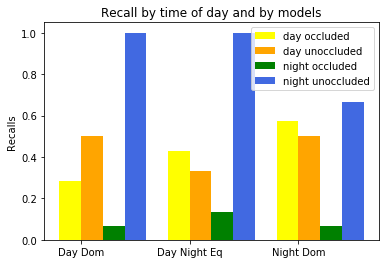

In [59]:
gridnumber = np.arange(3)
width = 0.2
fig = plt.figure()
ax = plt.subplot(111)
day_recall_oc = ax.bar(gridnumber, 
                    [dd_results['daytime']['recall_oc'],
                     dn_results['daytime']['recall_oc'], 
                     nd_results['daytime']['recall_oc']],
                     width, color='yellow')

day_recall_noc = ax.bar(gridnumber + width, 
                    [dd_results['daytime']['recall_noc'],
                     dn_results['daytime']['recall_noc'], 
                     nd_results['daytime']['recall_noc']],
                     width, color='orange')

night_recall_oc = ax.bar(gridnumber + width * 2, 
                    [dd_results['night']['recall_oc'], 
                     dn_results['night']['recall_oc'],
                     nd_results['night']['recall_oc']], 
                     width, color='green')

night_recall_noc = ax.bar(gridnumber + width * 3, 
                    [dd_results['night']['recall_noc'], 
                     dn_results['night']['recall_noc'],
                     nd_results['night']['recall_noc']], 
                     width, color='royalblue')

ax.set_xticks(gridnumber + width/2)
ax.set_xticklabels(['Day Dom', 'Day Night Eq', 'Night Dom'])   
ax.set_ylabel('Recalls')
ax.set_title('Recall by time of day and by models')
ax.legend((day_recall_oc[0], day_recall_noc[0], night_recall_oc[0], night_recall_noc[0]), ('day occluded', 'day unoccluded', 'night occluded', 'night unoccluded'))

Overall unoccluded pedestrians have much higher accuracy.
Now that we have accuracies fullview pedestrians vs occluded pedestrians, we can compare apples to apples, and calculate how much bias is actually unexplainable 

### Mean Difference ###

$$ d = p(y^+ | s^0) - p(y^+ | s^1)$$

### Calculate Unexplained Difference ###

Unexplained bias is overall bias minus explainable bias

$$ d_u = d - d_e $$

Explainable bias compares occluded accuracy vs occluded accuracy, non-occluded accuracy vs non-occluded

$$ d_e = \sum^{m}_{i=1} p^*(y^+ | z^i)(p(z^i|s^0) - p(z^i|s^1)$$
$$p*(y^+ | z^i) = \frac{p(y^+|s^0, z^i) + p(y^+|s^1, z^i)}{2}$$

In [60]:
# calculate conditional difference
def calc_unexp_diff(day_result, night_result):
    mean_diff = day_result['recall'] - night_result['recall']
    occ_accp = (day_result['recall_oc'] + night_result['recall_oc'])/2
    nocc_accp = (day_result['recall_noc'] + night_result['recall_noc'])/2
    prob_occ_night = night_result['num_gts_oc'] / night_result['num_gts']
    prob_nocc_night = (night_result['num_gts'] - night_result['num_gts_oc']) / night_result['num_gts']
    prob_occ_day = day_result['num_gts_oc'] / day_result['num_gts']
    prob_nocc_day = (day_result['num_gts'] - day_result['num_gts_oc']) / day_result['num_gts']

    exp_diff = occ_accp * (prob_occ_day - prob_occ_night) + nocc_accp * (prob_nocc_day - prob_nocc_night)
    
    unexp_diff = mean_diff - exp_diff
    print('mean difference', mean_diff, ', exp diff', exp_diff, ', unexp_diff', unexp_diff)
    
    return mean_diff, exp_diff



In [61]:
print('Day Dominated Model:')
dd_mean_diff, dd_exp_diff = calc_unexp_diff(dd_results['daytime'],dd_results['night'])
print('Day Night Equal Model:')
dn_mean_diff, dn_exp_diff = calc_unexp_diff(dn_results['daytime'],dn_results['night'])
print('Night Dominated Model:')
nd_mean_diff, nd_exp_diff = calc_unexp_diff(nd_results['daytime'],nd_results['night'])

Day Dominated Model:
mean difference 0.16239316239316243 , exp diff 0.16920024420024424 , unexp_diff -0.006807081807081811
Day Night Equal Model:
mean difference 0.10683760683760685 , exp diff 0.11373626373626375 , unexp_diff -0.006898656898656902
Night Dominated Model:
mean difference 0.3717948717948718 , exp diff 0.07793040293040294 , unexp_diff 0.2938644688644689


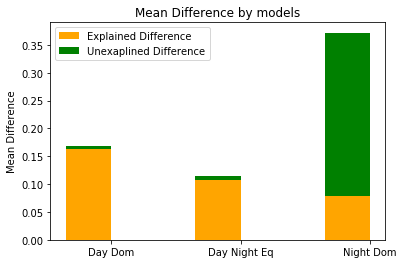

In [62]:
gridnumber = np.arange(3)
explained_diff = [dd_exp_diff, dn_exp_diff, nd_exp_diff]
unexplained_diff = [dd_mean_diff - dd_exp_diff, dn_mean_diff - dn_exp_diff, nd_mean_diff - nd_exp_diff]

width = 0.35
fig = plt.figure()
ax = plt.subplot(111)
exb1 = ax.bar(gridnumber, explained_diff, width, color='orange')
unb2 = ax.bar(gridnumber, unexplained_diff, width, bottom = explained_diff, color='green')
ax.set_xticks(gridnumber + width/2)
ax.set_xticklabels(['Day Dom', 'Day Night Eq', 'Night Dom'])   
ax.set_ylabel('Mean Difference')
ax.set_title('Mean Difference by models')
ax.legend((exb1[0], unb2[1]), ('Explained Difference', 'Unexaplined Difference'))

## Summary ##

Magnitude measures measure bias magnitude, however it does not distinguish between explainable vs none-explainable bias.

Conditional measures divides bias into explable vs none-explainable portions. However it is not easy to do. 